In [47]:
import numpy as np                                                      
import pandas as pd                                                    
import matplotlib.pyplot as plt                                        
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from nltk.corpus import stopwords
import re
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import euclidean_distances
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [48]:
df = pd.read_csv('shared_articles.csv')

In [49]:
df.head(5)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [50]:
df.isna().sum()

timestamp             0
eventType             0
contentId             0
authorPersonId        0
authorSessionId       0
authorUserAgent    2442
authorRegion       2442
authorCountry      2442
contentType           0
url                   0
title                 0
text                  0
lang                  0
dtype: int64

In [51]:
set(df['lang'])

{'en', 'es', 'ja', 'la', 'pt'}

In [52]:
# Limiting our recommendation to English Articles
df_main = df[df['lang']=='en']

In [53]:
set(df_main['lang'])

{'en'}

In [54]:
# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    """
    This function would convert some short letters into the forms that one 
    could easily understand respectively.
    """
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [55]:
def text_preprocessing(df, feature, stemming = False, lemmatize = True):
    pattern = "[^a-zA-Z0-9]"
    english_stopwords = stopwords.words("english")
    preprocessed_text = []
    for i in tqdm(range(len(df[feature]))):
        text = decontracted(df[feature].iloc[i])
        text = re.sub(pattern, ' ', text)
        text = text.lower()
        text = word_tokenize(text)
        text = [word for word in text if word not in english_stopwords]
        text = [word for word in text if word not in string.punctuation]
        if stemming:
            porter_stemmer = PorterStemmer()
            text = " ".join([porter_stemmer.stem(word) for word in text])
        if lemmatize:
            lemmatizer = WordNetLemmatizer()
            text = " ".join([lemmatizer.lemmatize(word) for word in text])
        preprocessed_text.append(text)
    
    return preprocessed_text

In [61]:
preprocessed_text = text_preprocessing(df_main, feature = "text")

100%|██████████████████████████████████████| 2264/2264 [00:09<00:00, 243.46it/s]


In [63]:
len(preprocessed_text)

2264

In [64]:
preprocessed_title = text_preprocessing(df_main, feature = "title")

100%|█████████████████████████████████████| 2264/2264 [00:00<00:00, 9937.72it/s]


In [65]:
len(preprocessed_title)

2264

# Recommendation based on just the Items - Articles
##### At an overall level
##### Assuming no User Information is available
Generating the recommendations based on similarity of items- Clustering like problem

In [21]:
# All the columns are unimportant but text/ title
df_main.columns

Index(['timestamp', 'eventType', 'contentId', 'authorPersonId',
       'authorSessionId', 'authorUserAgent', 'authorRegion', 'authorCountry',
       'contentType', 'url', 'title', 'text', 'lang'],
      dtype='object')

TF-IDF
* TF(t) = (Number of times term 't' appears in a document) / (Total number of terms in the document)
* IDF(t) = log_e(Total number of documents / Number of documents with term 't' in it)

In [134]:
vectorizer = TfidfVectorizer(stop_words='english')

In [135]:
tfidf_vectorizer_text = vectorizer.fit_transform(preprocessed_text)

In [87]:
# tfidf_vectorizer_title = vectorizer.fit_transform(preprocessed_title)

* Inertia actually calculates the sum of distances of all the points within a cluster from the centroid of that cluster
* Along with the distance between the centroid and points, the Dunn index also takes into account the distance between two clusters

#### Clustering for "Text"

In [113]:
# sum of the squared Euclidean distances of each point to its closest centroid
sse = {}

for i in range(2,25):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100).fit(tfidf_vectorizer_text)
    df_main["clusters"] = kmeans.labels_
    sse[i] = kmeans.inertia_

/var/folders/3c/q875p1_979j40ck65t4g0y640000gn/T/ipykernel_72613/2355151510.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main["clusters"] = kmeans.labels_
/var/folders/3c/q875p1_979j40ck65t4g0y640000gn/T/ipykernel_72613/2355151510.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main["clusters"] = kmeans.labels_
/var/folders/3c/q875p1_979j40ck65t4g0y640000gn/T/ipykernel_72613/2355151510.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

/var/folders/3c/q875p1_979j40ck65t4g0y640000gn/T/ipykernel_72613/2355151510.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main["clusters"] = kmeans.labels_
/var/folders/3c/q875p1_979j40ck65t4g0y640000gn/T/ipykernel_72613/2355151510.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main["clusters"] = kmeans.labels_


Text(0, 0.5, 'Inertia')

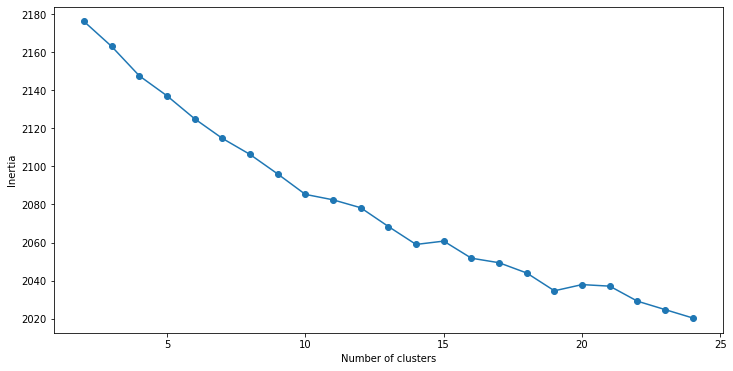

In [114]:
# Plotting the curve with 'k'-value vs distance
plt.figure(figsize=(12,6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")

In [118]:
tfidf_vectorizer_text.shape

(2264, 40459)

In [119]:
# Use silhouette score to find optimal number of clusters

res = {}
for i in range(2,25):
    
    model = KMeans(n_clusters = i).fit(tfidf_vectorizer_text)
    pred = model.predict(tfidf_vectorizer_text)
    res[i] = silhouette_score(tfidf_vectorizer_text, pred)

#optimum = max(res, key=res.get)

The coefficient combines the average within-cluster distance with average nearest-cluster distance to assign a value between -1 and 1. A value below zero denotes that the observation is probably in the wrong cluster and a value closer to 1 denotes that the observation is a great fit for the cluster and clearly separated from other clusters.


ref: https://www.jeremyjordan.me/grouping-data-points-with-k-means-clustering/

In [121]:
best_k = 14

In [122]:
# model with k different centroid initializations and maximum iterations of 500
k_model_text = KMeans(n_clusters=best_k, init='k-means++', max_iter=500, n_init=best_k)

In [123]:
k_model_text.fit(tfidf_vectorizer_text)

KMeans(max_iter=500, n_clusters=14, n_init=14)

In [141]:
# Previewing top 14 words in each cluster

print("Top words in each cluster:")
order_centroids = k_model_text.cluster_centers_.argsort()[:, ::-1]
words = vectorizer.get_feature_names()
for i in range(best_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :14]:
        print(' %s' % words[ind]),

Top words in each cluster:
Cluster 0:
 bug
 specification
 unknown
 quality
 missing
 fight
 discovery
 software
 save
 stage
 implementation
 technique
 xolv
 tzu
Cluster 1:
 bank
 banking
 payment
 customer
 card
 digital
 financial
 account
 service
 fintech
 credit
 mobile
 merchant
 institution
Cluster 2:
 customer
 company
 digital
 business
 consumer
 brand
 product
 marketing
 technology
 new
 data
 market
 service
 insurance
Cluster 3:
 google
 cloud
 data
 gcp
 platform
 service
 search
 app
 company
 apps
 new
 user
 machine
 customer
Cluster 4:
 code
 file
 java
 use
 javascript
 server
 application
 test
 event
 node
 data
 api
 method
 web
Cluster 5:
 apple
 mac
 iphone
 job
 siri
 steve
 io
 new
 device
 watch
 cook
 ibm
 app
 company
Cluster 6:
 android
 google
 app
 vr
 mobile
 apps
 developer
 device
 window
 preview
 phone
 new
 io
 user
Cluster 7:
 docker
 container
 kubernetes
 image
 run
 cluster
 application
 cloud
 command
 running
 engine
 build
 swarm
 linux
C